# EDA AIR QUALITY
---
`En este cuadernillo se realiza el análisis exploratorio del dataset airquality.arrow`

### Importación de librerías
---

*Para este cuaderno usaremos las siguientes librerías: **os, polars, pandas, datetime, numpy, pyarrow y sodapy**.*

In [2]:
import os
import polars as pl
import polars.selectors as cs
import pandas as pd
from datetime import date, time
import numpy as np
import pyarrow.parquet as pq
from sodapy import Socrata

#### **Web Scraping / Extracción de los datos** ####
---

*Para este cuaderno usaremos la api de datos oficiales de la ciudad de Nueva York para epxlorar las cifras oficiales de la calidad del aire.*

1. Usamos la biblioteca sodapy que nos proporciona una interfaz de cliente para interactuar con la API de Socrata, una plataforma de datos abiertos usada por la ciudad de Nueva York e inicializamos el cliente para interactuar con el portal de datos abiertos de la ciudad. En este caso no necesitamos autenticación por lo que se determina el argumento en None.

2. Creamos una variable que cuente la cantidad total de datos que tiene la api, para traer toda la información que tenga hasta la última actualización

3. Obtenemos los datos de la API estableciendo un id para el ingreso y se establece un limite usando la variable total_filas que es la cantidad total de datos que tiene la API.

4. Convertirmos los datos a un dataframe de Pandas.

In [3]:
# Abrimos el dataset directamente de la API
client = Socrata("data.cityofnewyork.us", None)

# Obtenemos la cantidad total de filas en el conjunto de datos.
total_filas = int(client.get("c3uy-2p5r", select="COUNT(*)")[0]['COUNT'])

# Obtener los datos del conjunto de datos.
results = client.get("c3uy-2p5r", limit=total_filas)

# Convertir a dataframe de Pandas (16218, 12)
dfAirQuality = pd.DataFrame.from_records(results)

### **Análisis Exploratorio Inicial** ###
---

*Vamos a realizar una **exploración de los datos** (EDA) antes de hacer transformación de los mismos, esto con el fin de **conocer las columnas** y determinar que campos son valiosos para nuestro análisis y así tener claro que pasos realizaremos en el ETL.*

**Nota:**: *Posterior al ETL realizaremos también un EDA enfocado en los datos y una descripción estadística.*

#### **Revisión de la extracción de los datos** ####

*Revisamos que los datos se cargaron adecuadamente en nuestro dataframe **dfAirQuality**:*

1. *Usamos **head** para previsualizar los primeros registros del Dataframe.*
2. *Podemos observar que se cargaron adecuadamente los datos, por ahora no vemos anomalías en los mismos.*

In [4]:
dfAirQuality.head(5)

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,827080,386,Ozone (O3),Mean,ppb,UHF34,104,Pelham - Throgs Neck,Summer 2022,2022-06-01T00:00:00.000,33.3
1,827061,386,Ozone (O3),Mean,ppb,UHF34,405,Ridgewood - Forest Hills,Summer 2022,2022-06-01T00:00:00.000,34.2
2,827067,386,Ozone (O3),Mean,ppb,UHF34,302,Central Harlem - Morningside Heights,Summer 2022,2022-06-01T00:00:00.000,30.9
3,827081,386,Ozone (O3),Mean,ppb,UHF34,103,Fordham - Bronx Pk,Summer 2022,2022-06-01T00:00:00.000,31.7
4,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104,Pelham - Throgs Neck,Summer 2022,2022-06-01T00:00:00.000,12.0


#### **Revisión de la forma de los datos** ####

1. *Usamos **shape** obtener el número de filas y columnas del dataframe.*

In [5]:
dfAirQuality.shape

(18025, 11)

#### **Exploración de las columnas** ####

*Vamos a revisar qué columnas existen en el dataframe y de qué tipo son:*

1. *Usamos el método **info()** para listar las columnas, su valores no nulos y sus tipos.*
2. *Observamos que no tenemos registros nulos y que todas la variables son de tipo object*

In [6]:
dfAirQuality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18025 entries, 0 to 18024
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   unique_id       18025 non-null  object
 1   indicator_id    18025 non-null  object
 2   name            18025 non-null  object
 3   measure         18025 non-null  object
 4   measure_info    18025 non-null  object
 5   geo_type_name   18025 non-null  object
 6   geo_join_id     18016 non-null  object
 7   geo_place_name  18016 non-null  object
 8   time_period     18025 non-null  object
 9   start_date      18025 non-null  object
 10  data_value      18025 non-null  object
dtypes: object(11)
memory usage: 1.5+ MB


##### Revisamos cada una de las columnas

*Con el fin de explorar a nivel de detalle el dataset obtenido realizamos un análisis por columna con el fin de tomar decisiones sobre la ideonidad de los datos y depurar información innecesaria.*

**Columna unique_id**

In [7]:
# Revisamos que efectivamente esta tabla cuente con identificadores únicos
# Creamos la distribución de frecuencias para observar si hay valores repetidos.
dfAirQuality.unique_id.value_counts().sort_index()

unique_id
121644    1
121645    1
121646    1
121647    1
121648    1
         ..
828349    1
828350    1
828351    1
828352    1
828353    1
Name: count, Length: 18025, dtype: int64

In [8]:
# Observamos que esta columna cuenta con los identificadores de cada registro, sin embargo al ser id que no tienen relación con otras tablas, podemos eliminar esta columna
dfAirQuality.drop('unique_id', axis=1, inplace=True)

**Columna start_date**

In [9]:
# Creamos una tabla de frecuencias para revisar sus valores 
dfAirQuality.start_date.value_counts().sort_index()

start_date
2005-01-01T00:00:00.000    897
2008-12-01T00:00:00.000    564
2009-01-01T00:00:00.000    480
2009-06-01T00:00:00.000    564
2009-12-01T00:00:00.000    564
2010-01-01T00:00:00.000    321
2010-06-01T00:00:00.000    423
2010-12-01T00:00:00.000    564
2011-01-01T00:00:00.000    214
2011-06-01T00:00:00.000    423
2011-12-01T00:00:00.000    564
2012-01-02T00:00:00.000    480
2012-06-01T00:00:00.000    423
2012-12-01T00:00:00.000    564
2013-01-01T00:00:00.000    144
2013-06-01T00:00:00.000    423
2013-12-01T00:00:00.000    564
2014-01-01T00:00:00.000     96
2014-06-01T00:00:00.000    423
2014-12-01T00:00:00.000    282
2015-01-01T00:00:00.000    906
2015-06-01T00:00:00.000    423
2015-12-01T00:00:00.000    282
2015-12-31T00:00:00.000    282
2016-06-01T00:00:00.000    423
2016-12-01T00:00:00.000    282
2017-01-01T00:00:00.000    771
2017-06-01T00:00:00.000    423
2017-12-01T00:00:00.000    282
2018-01-01T00:00:00.000    282
2018-06-01T00:00:00.000    423
2018-12-01T00:00:00.000    2

In [10]:
# Convertimos el tipo de esta columna a datetime.
dfAirQuality["start_date"] = pd.to_datetime(dfAirQuality["start_date"])

In [11]:
# Filtramos el dataframe para incluir solo los registros de los últimos 3 años y eliminamos la hora, ya que no es relevante.
dfAirQuality = dfAirQuality[(dfAirQuality['start_date'].dt.year >= 2019)]
dfAirQuality['start_date'] = dfAirQuality['start_date'].dt.date

In [12]:
# Verificamos los cambios realizados
dfAirQuality.start_date.value_counts()

start_date
2019-01-01    603
2022-06-01    423
2021-06-01    423
2020-06-01    423
2019-06-01    423
2022-01-01    282
2021-12-01    282
2021-01-01    282
2020-12-01    282
2020-01-01    282
2019-12-01    282
Name: count, dtype: int64

**Columna indicator_id y name**

In [13]:
# Comparamos los valores de indicator_id y observamos que presentan la misma distribución de los datos
dfAirQuality.indicator_id.value_counts()

indicator_id
375    1551
365    1551
386     564
644     107
645     107
643     107
Name: count, dtype: int64

In [14]:
# Comparamos los valores de name
dfAirQuality.name.value_counts()

name
Nitrogen dioxide (NO2)                    1551
Fine particles (PM 2.5)                   1551
Ozone (O3)                                 564
Annual vehicle miles traveled (cars)       107
Annual vehicle miles traveled (trucks)     107
Annual vehicle miles traveled              107
Name: count, dtype: int64

In [15]:
# Mapeamos los valores y los reemplazamos
mapeo_name = {
    "Nitrogen dioxide (NO2)": "NO2",
    "Fine particles (PM 2.5)": "PM 2.5",
    "Ozone (O3)": "O3"
}

dfAirQuality["name"] = dfAirQuality["name"].replace(mapeo_name)

In [16]:
# Eliminamos la columna 'indicator_id'
dfAirQuality.drop("indicator_id", axis=1, inplace=True)

**Columna measure**

In [17]:
# Si contamos los valores que toma esta columna, observamos que todas se calculan como la media
dfAirQuality.measure.value_counts()

measure
Mean             3666
Million miles     321
Name: count, dtype: int64

In [18]:
# Eliminamos la columna measure ya que no nos aporta información
dfAirQuality.drop("measure", axis=1, inplace=True)

**Columna measure_info y data_value**
1. Se normalizarán los datos existentes a un tipo de medida y se convertirán a valores medidos en mcg/m3.

In [19]:
# Observamos que existen dos medidas de referencia: partes por billon y microgramos por metro cúbico
dfAirQuality.measure_info.value_counts()

measure_info
ppb                2115
mcg/m3             1551
per square mile     321
Name: count, dtype: int64

In [20]:
dfAirQuality.start_date.value_counts()

start_date
2019-01-01    603
2022-06-01    423
2021-06-01    423
2020-06-01    423
2019-06-01    423
2022-01-01    282
2021-12-01    282
2021-01-01    282
2020-12-01    282
2020-01-01    282
2019-12-01    282
Name: count, dtype: int64

In [21]:
# Convertimos el tipo de dato de la columna data_value a float.
dfAirQuality["data_value"] = dfAirQuality["data_value"].astype(float)

In [22]:
# Definimos las masas molares de los gases contaminantes teniendo en cuenta los pesos atómicos que los componen.
masaOzono = 3 * 16
masaNitrogeno = 14 + 2 * 16
masaPM = 3.625 #Este es un estándar para el material particulado.

# Mapeamos estos valores teniendo en cuenta los nombres de los componentes para luego aplicarlos a la función
masa_map = {
    "O3": masaOzono,
    "NO2": masaNitrogeno,
    "PM 2.5": masaPM,
}

In [23]:
# Definimos los promedios de temperatura teniendo en cuenta los datos historicos de temperatura por meses
temEne = 0.5
temJun = 22.5
temDic = 3.5

# Creamos una función que nos permita identificar el mes y asignarle un valor de temperatura
def obtener_tem(mes):
    if mes == 1:  # Enero
        return temEne
    elif mes == 6:  # Junio
        return temJun
    elif mes == 12:  # Diciembre
        return temDic
    else:
        return None
    
# Creamos una nueva columna que contenga la temperatura promedio para ese mes.
dfAirQuality["tem"] = pd.to_datetime(dfAirQuality["start_date"]).dt.month.apply(obtener_tem)

In [24]:
# Creamos una función que nos permite hacer la conversión tomando como parámetros la medida en ppb, la temperatura y la masa.
def calcular_mcg(ppb, tem, masa):
    kelvin = tem + 273.15
    vol = 0.082 * kelvin
    res = (ppb * 1000 * masa * 10 **6) / (10 **9 * vol)
    return round(res,2)

In [25]:
# Aplicamos la función de conversión para crear la nueva columna, solo convertiremos aquellos valores que se encuentren en ppb.
dfAirQuality["mcg/m3"] = dfAirQuality.apply(lambda row: calcular_mcg(row["data_value"], row["tem"], masa_map[row["name"]])
                               if row["measure_info"] == "ppb" else row["data_value"], axis=1)

In [26]:
# Eliminamos las columnas que measure_info, data_value y tem
dfAirQuality.drop("measure_info", axis=1, inplace=True)
dfAirQuality.drop("data_value", axis=1, inplace=True)
dfAirQuality.drop("tem", axis=1, inplace=True)

**Columna time_period**

1. Esta columna representa el periodo de tiempo en el que se tomaron los datos, esto puede ser anual o semestral (Invierno y Verano).

In [27]:
dfAirQuality.time_period.value_counts()

time_period
Summer 2022            423
Summer 2021            423
Summer 2020            423
Summer 2019            423
2019                   321
Annual Average 2022    282
Winter 2021-22         282
Annual Average 2021    282
Winter 2020-21         282
Annual Average 2020    282
Winter 2019-20         282
Annual Average 2019    282
Name: count, dtype: int64

In [28]:
# Renombramos los valores de las variables para que solo sean: Año, Invierno, Verano
mapeo_time_period = {
    "Summer 2020": "Verano",
    "Summer 2021": "Verano",
    "Summer 2019": "Verano",
    "Annual Average 2020": "Año",
    "Annual Average 2021": "Año",
    "Annual Average 2019": "Año",
    "Winter 2020-21": "Invierno",
    "Winter 2019-20": "Invierno",
}

dfAirQuality["time_period"] = dfAirQuality["time_period"].replace(mapeo_time_period)

**Renombramos las columnas**

1. *Renombramos las columnas para mejorar la comprensión de los datos.*

In [29]:
dfAirQuality = dfAirQuality.rename(columns={"name": "Contaminante", "geo_type_name": "Division", "geo_join_id": "IdLoc",
                                            "geo_place_name": "NombreLugar",  "time_period": "PeriodoTiempo",  "start_date": "FechaInicio"})
dfAirQuality.head(3)

,Contaminante,Division,IdLoc,NombreLugar,PeriodoTiempo,FechaInicio,mcg/m3
0,O3,UHF34,104,Pelham - Throgs Neck,Summer 2022,2022-06-01,65.93
1,O3,UHF34,405,Ridgewood - Forest Hills,Summer 2022,2022-06-01,67.71
2,O3,UHF34,302,Central Harlem - Morningside Heights,Summer 2022,2022-06-01,61.18


**Columna Division, IdLoc, NombreLugar**

1. Según el diccionario de datos de la fuente oficial estas columnas representan la zona sobre la cual se toma la medición, estas mediciones se tomaron en distintos niveles (Citywide = A nivel de ciudad), (Borough = A nivel de cada Distrito (Borough)), (UHF 34 y UHF 42 = A nivel de Zonas de planificación de servicios de salud) y (CD =Distritos comunitarios)
2. Observamos la distribución de datos que tenemos por división.
3. Vamos a separar los datos de acuerdo a la división de la ciudad, así en el análisis podremos analizar los datos a diferentes escalas.

In [30]:
dfAirQuality.Division.value_counts()

Division
CD          1711
UHF42       1218
UHF34        884
Borough      145
Citywide      29
Name: count, dtype: int64

**Dataframe AirQualityNewYorkCity**

1. *Este dataframe contiene los medidas generales de la ciudad en cuanto a niveles de contaminantes en el aire.*
2. *Eliminamos las columnas de localización ya que este dataframe solo se refiere a la ciudad de Nueva York en conjunto.*

In [31]:
# Creamos el dataframe con los datos generales de la ciudad.
dfAQNYC = dfAirQuality.loc[dfAirQuality["Division"].str.contains("Citywide")].copy()
dfAQNYC.drop(columns=["Division","IdLoc", "NombreLugar"], axis=1, inplace=True)
dfAQNYC.sort_values(by=["FechaInicio"], inplace=True)
dfAQNYC.head(3)

,Contaminante,PeriodoTiempo,FechaInicio,mcg/m3
3785,PM 2.5,Año,2019-01-01,6.6
3572,Annual vehicle miles traveled,2019,2019-01-01,59.6
3571,Annual vehicle miles traveled (trucks),2019,2019-01-01,3.2


**Dataframe AirQualityBoroughs**

1. Este dataframe contiene los medidas generales de los 5 boroughs de la ciudad en cuanto a niveles de contaminantes en el aire.
2. Eliminamos las columnas que no son necesarias
3. Mapeamos los id de los boroughs para que coincidan con las fuentes oficiales

In [32]:
# Creamos el dataframe con los datos de cada uno de los 5 boroughs
dfAQBoroughs = dfAirQuality.loc[dfAirQuality["Division"].str.contains("Borough")].copy()
dfAQBoroughs.drop(columns=["Division"], axis=1, inplace=True)
dfAQBoroughs.head(3)

,Contaminante,IdLoc,NombreLugar,PeriodoTiempo,FechaInicio,mcg/m3
30,NO2,5,Staten Island,Summer 2022,2022-06-01,14.80
45,O3,3,Manhattan,Summer 2022,2022-06-01,59.79
73,PM 2.5,4,Queens,Summer 2022,2022-06-01,6.40


In [33]:
# Mapeamos los id de los boroughs para que coincidan con los id oficiales de los boroughs de NYC.
mapeo_borough = {
    "1": 2,
    "2": 3,
    "3": 1,
    "4": 4,
    "5": 5
}
dfAQBoroughs["IdLoc"] = dfAirQuality["IdLoc"].replace(mapeo_borough)

In [34]:
# Creamos un dataframe que contenga los códigos de cada Borough y su nombre
dfBor = dfAQBoroughs[["IdLoc", "NombreLugar"]].drop_duplicates().sort_values(by="IdLoc")
dfBor.rename(columns={"IdLoc": "IdBorough", "NombreLugar": "Nombre"}, inplace=True)
dfBor["IdBorough"] = dfBor["IdBorough"].astype(int)
dfBor


,IdBorough,Nombre
45,1,Manhattan
148,2,Bronx
98,3,Brooklyn
73,4,Queens
30,5,Staten Island


In [35]:
# Eliminamos la columna nombre lugar, ya que no será necesaria.
dfAQBoroughs.drop(columns=["NombreLugar"], axis=1, inplace=True)

In [36]:
# Reordenamos el dataframe para mejorar la lectura del mismo y cambiamos el nombre de la columna Id
dfAQBoroughs = dfAQBoroughs.reindex(columns=["IdLoc", "FechaInicio","PeriodoTiempo", "Contaminante", "mcg/m3" ])
dfAQBoroughs.rename(columns={"IdLoc": "IdBorough"}, inplace=True)
dfAQBoroughs.sort_values(by=["IdBorough", "FechaInicio"], inplace=True)
dfAQBoroughs["IdBorough"] = dfAQBoroughs["IdBorough"].astype(int)

dfAQBoroughs

,IdBorough,FechaInicio,PeriodoTiempo,Contaminante,mcg/m3
3581,1,2019-01-01,Año,NO2,44.48
3599,1,2019-01-01,2019,Annual vehicle miles traveled (cars),116.70
3758,1,2019-01-01,2019,Annual vehicle miles traveled,129.50
3829,1,2019-01-01,2019,Annual vehicle miles traveled (trucks),7.30
3865,1,2019-01-01,Año,PM 2.5,8.30
...,...,...,...,...,...
669,5,2022-01-01,Annual Average 2022,NO2,22.96
684,5,2022-01-01,Annual Average 2022,PM 2.5,5.20
30,5,2022-06-01,Summer 2022,NO2,14.80
260,5,2022-06-01,Summer 2022,O3,69.89


**Dataframes UHF34 y UHF42**

1. *Este dataframe contiene los medidas generales de 34 y 42 zonas de planificación de servicios de salud, que agrupan un conjunto de barrios en cuanto a niveles de contaminantes en el aire.*
2. *Eliminamos las columnas que no son necesarias*
3. *No se usarán estos dataframes para el análisis*

In [37]:
# Creamos el dataframe con los datos de cada uno las 34 zonas de planificación de servicios de salud, sin embargo esta información no la usaremos.
dfAQUHF34 = dfAirQuality.loc[dfAirQuality["Division"].str.contains("UHF34")].copy()
dfAQUHF34.drop(columns=["Division"], axis=1, inplace=True)
dfAQUHF34.head(3)

,Contaminante,IdLoc,NombreLugar,PeriodoTiempo,FechaInicio,mcg/m3
0,O3,104,Pelham - Throgs Neck,Summer 2022,2022-06-01,65.93
1,O3,405,Ridgewood - Forest Hills,Summer 2022,2022-06-01,67.71
2,O3,302,Central Harlem - Morningside Heights,Summer 2022,2022-06-01,61.18


In [38]:
# Creamos el dataframe con los datos de cada una de las 42 zonas de planificación de servicios de salud, sin embargo esta información no la usaremos.
dfAQUHF42 = dfAirQuality.loc[dfAirQuality["Division"].str.contains("UHF42")].copy()
dfAQUHF42.drop(columns=["Division"], axis=1, inplace=True)
dfAQUHF42.head(3)

,Contaminante,IdLoc,NombreLugar,PeriodoTiempo,FechaInicio,mcg/m3
5,NO2,502,Stapleton - St. George,Summer 2022,2022-06-01,16.51
15,PM 2.5,106,High Bridge - Morrisania,Summer 2022,2022-06-01,7.10
21,PM 2.5,406,Fresh Meadows,Summer 2022,2022-06-01,6.30


**Dataframe Distritos Comunitarios**

1. *Este dataframe contiene los medidas generales de los 59 Distritos Comunitarios que existen en la ciudad que agrupan un conjunto de barrios en cuanto a niveles de contaminantes en el aire.*
2. *Eliminamos las columnas que no son necesarias*
3. *Creamos un dataframe con la información de cada uno de los distritos.*

In [39]:
# Creamos el dataframe con los datos de cada uno de los 59 Distritos Comunitarios
dfAQCD = dfAirQuality.loc[dfAirQuality['Division'].str.contains("CD")].copy()
dfAQCD.drop(columns=["Division"], axis=1, inplace=True)
dfAQCD.head(3)

,Contaminante,IdLoc,NombreLugar,PeriodoTiempo,FechaInicio,mcg/m3
10,PM 2.5,412,Jamaica and Hollis (CD12),Summer 2022,2022-06-01,6.30
11,PM 2.5,104,Clinton and Chelsea (CD4),Summer 2022,2022-06-01,8.00
12,NO2,414,Rockaway and Broad Channel (CD14),Summer 2022,2022-06-01,13.09


In [40]:
# Creamos un dataframe que contenga los códigos de cada Distrito Comunitario y su nombre, eliminando los parentesis.
dfCD = dfAQCD[["IdLoc", "NombreLugar"]].drop_duplicates().sort_values(by="IdLoc")
dfCD.rename(columns={"IdLoc": "IdCD", "NombreLugar": "Nombre"}, inplace=True)
dfCD['Nombre'] = dfCD['Nombre'].str.replace(r"\(.*\)", "", regex=True)
dfCD["IdCD"] = dfCD["IdCD"].astype(int)

# Eliminamos la columna nombre lugar, ya que no será necesaria.
dfAQCD.drop(columns=["NombreLugar"], axis=1, inplace=True)

In [41]:
# Reordenamos el dataframe para mejorar la lectura del mismo y cambiamos el nombre de la columna Id
dfAQCD = dfAQCD.reindex(columns=["IdLoc", "FechaInicio", "PeriodoTiempo", "Contaminante", "mcg/m3" ])
dfAQCD.rename(columns={"IdLoc": "IdCD"}, inplace=True)
dfAQCD.sort_values(by=["IdCD", "FechaInicio"], inplace=True)
dfAQCD["IdCD"] = dfAQCD["IdCD"].astype(int)

dfAQCD

,IdCD,FechaInicio,PeriodoTiempo,Contaminante,mcg/m3
3594,101,2019-01-01,2019,Annual vehicle miles traveled (cars),103.70
3605,101,2019-01-01,2019,Annual vehicle miles traveled (trucks),4.90
3625,101,2019-01-01,2019,Annual vehicle miles traveled,116.30
3871,101,2019-01-01,Año,PM 2.5,8.40
3954,101,2019-01-01,Año,NO2,49.81
...,...,...,...,...,...
454,503,2022-01-01,Annual Average 2022,PM 2.5,5.00
587,503,2022-01-01,Annual Average 2022,NO2,19.06
155,503,2022-06-01,Summer 2022,NO2,12.90
332,503,2022-06-01,Summer 2022,PM 2.5,5.60


#### **Exportación de los datos** ####

*Realizamos la exportación de los dataframes a formato .arrow*

1. *Convertimos el dataframe a polars*
2. *Convertimos el dataframe de polar a un objeto arrow*

In [42]:
# Convertimos el dataframe Air Quality New York City
dfAQNYC = pl.from_pandas(dfAQNYC)
arrowAQNYC = dfAQNYC.to_arrow()
pq.write_table(arrowAQNYC, '../datasets/processed/aq_NYC.arrow')

# Convertimos el dataframe Air Quality Boroughs
dfAQBoroughs = pl.from_pandas(dfAQBoroughs)
arrowAQBoroughs = dfAQBoroughs.to_arrow()
pq.write_table(arrowAQBoroughs, '../datasets/processed/aq_boroughs.arrow')

# Convertimos el dataframe Boroughs
dfBor = pl.from_pandas(dfBor)
arrowBor = dfBor.to_arrow()
pq.write_table(arrowBor, '../datasets/processed/boroughs.arrow')

# Convertimos el dataframe Air Quality Community Districts
dfAQCD = pl.from_pandas(dfAQCD)
arrowAQCD = dfAQCD.to_arrow()
pq.write_table(arrowAQCD, '../datasets/processed/aq_cd.arrow')

# Convertimos el dataframe Community Districts
dfCD = pl.from_pandas(dfCD)
arrowCD = dfCD.to_arrow()
pq.write_table(arrowCD, '../datasets/processed/community_districts.arrow')


# EDA EMISIONES CO2 POR PAÍS, AÑO, TIPO DE ENERGÍA, Y OTRAS VARIABLES
---
`En este cuadernillo se realiza el análisis exploratorio del archivo 'energy.csv' contenido dentro del zip 'archive.zip'`

### Importación de librerías
---

Para este cuaderno usaremos las siguientes librerías: **pandas, datetime, matplotlib y seaborn**.

In [43]:
import pandas as pd
from datetime import date, time
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#### **Web Scraping / Extracción de los datos** ####
---
1. Usaremos la información almacenada en el enlace 'https://www.kaggle.com/datasets/lobosi/c02-emission-by-countrys-grouth-and-population' que contiene datasets acerca de las emisiones de CO2 por país, año, tipo de energía, entre otros
2. Estos archivos son descargados y almacenados localmente para su análisis y son convertidos a un dataframe de Pandas.

In [206]:
# ruta al archivo zip
ruta_zip = '..\\..\\datasets\\raw\\archive.zip'

#lista para almacenar los datos de los archivos csv
datos_csv = []

#abrir el archivo zip y leer los csv
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    #recorrer cada archivo en el zip
    for nombre_archivo in zip_ref.namelist():
        #extraer archivo
        with zip_ref.open(nombre_archivo) as archivo_csv:
            #leer csv y almacenar datos en un df
            datos = pd.read_csv(archivo_csv, sep=',', encoding='utf-8')
            #agregar los datos a la lista
            datos_csv.append(datos)

#concatenar todos los df en uno solo
df_emisiones = pd.concat(datos_csv, ignore_index = True)

### **Análisis Exploratorio Inicial** ###
---

*Vamos a realizar una **exploración de los datos** (EDA) antes de hacer transformación de los mismos, esto con el fin de **conocer las columnas** y determinar que campos son valiosos para nuestro análisis y así tener claro que pasos realizaremos en el ETL.*

**Nota:**: *Posterior al ETL realizaremos también un EDA enfocado en los datos y una descripción estadística.*

#### **Revisión de la extracción de los datos** ####

*Revisamos que los datos se cargaron adecuadamente en nuestro dataframe **df_emisiones**:*

1. *Usamos **head** para previsualizar los primeros registros del Dataframe.*

In [207]:
df_emisiones.head()

,Unnamed: 0,Country,Energy_type,Year,Energy_consumption,Energy_production,GDP,Population,Energy_intensity_per_capita,Energy_intensity_by_GDP,CO2_emission
0,0,World,all_energy_types,1980,292.899790,296.337228,27770.910281,4.298127e+06,68.145921,10.547,4946.627130
1,1,World,coal,1980,78.656134,80.114194,27770.910281,4.298127e+06,68.145921,10.547,1409.790188
2,2,World,natural_gas,1980,53.865223,54.761046,27770.910281,4.298127e+06,68.145921,10.547,1081.593377
3,3,World,petroleum_n_other_liquids,1980,132.064019,133.111109,27770.910281,4.298127e+06,68.145921,10.547,2455.243565
4,4,World,nuclear,1980,7.575700,7.575700,27770.910281,4.298127e+06,68.145921,10.547,0.000000


#### **Revisión de la forma de los datos** ####

1. *Usamos **shape** obtener el número de filas y columnas del dataframe.*

In [208]:
df_emisiones.shape

(55440, 11)

#### **Exploración de las columnas** ####

*Vamos a revisar qué columnas existen en el dataframe y de qué tipo son:*

1. *Usamos el método **info()** para listar las columnas, su valores no nulos y sus tipos.*

In [66]:
df_emisiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55440 entries, 0 to 55439
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   55440 non-null  int64  
 1   Country                      55440 non-null  object 
 2   Energy_type                  55440 non-null  object 
 3   Year                         55440 non-null  int64  
 4   Energy_consumption           44287 non-null  float64
 5   Energy_production            44289 non-null  float64
 6   GDP                          40026 non-null  float64
 7   Population                   46014 non-null  float64
 8   Energy_intensity_per_capita  50358 non-null  float64
 9   Energy_intensity_by_GDP      50358 non-null  float64
 10  CO2_emission                 51614 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 4.7+ MB


#### **Búsqueda y eliminación de duplicados** ####

*Revisamos los registros que pudieran estar duplicados basados en todas las columnas:*

1. *Usamos el método **drop_duplicates()***
2. *Observamos la cantidad de registros posterior a la eliminación de duplicados*

In [209]:
df_emisiones = df_emisiones.drop_duplicates()

df_emisiones.shape

(55440, 11)

In [68]:
# Vemos la cantidad de países que se encuentran en el listado:
df_emisiones['Country'].unique()

array(['World', 'Afghanistan', 'Albania', 'Algeria', 'American Samoa',
       'Angola', 'Antarctica', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo-Brazzaville',
       'Congo-Kinshasa', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Côte d’Ivoire', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Falkland Islands', 'Faroe Islands',

In [69]:
# Vemos los tipos de emisiones que están contempladas en el dataset
df_emisiones['Energy_type'].unique()

array(['all_energy_types', 'coal', 'natural_gas',
       'petroleum_n_other_liquids', 'nuclear', 'renewables_n_other'],
      dtype=object)

In [70]:
# Vemos la temporalidad de los datos
df_emisiones['Year'].unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

In [210]:
# Filtramos por país 'United States' ya que solo nos sirven los registros pertenecientes a este pais
df_emisiones_usa = df_emisiones[df_emisiones['Country'] == 'United States']

# Nos sirve en este caso las energías derivadas del petróleo además de las renovables
emisiones_usa = df_emisiones_usa.loc[(df_emisiones_usa['Energy_type'] == 'petroleum_n_other_liquids') | (df_emisiones_usa['Energy_type'] == 'renewables_n_other')]

# Vemos como queda la tabla post-filtros
emisiones_usa.head(10)

,Unnamed: 0,Country,Energy_type,Year,Energy_consumption,Energy_production,GDP,Population,Energy_intensity_per_capita,Energy_intensity_by_GDP,CO2_emission
1323,1323,United States,petroleum_n_other_liquids,1980,34.158965,20.473758,7080.75,227119.0,343.525258,11.018764,2455.243565
1325,1325,United States,renewables_n_other,1980,5.428342,5.428342,7080.75,227119.0,343.525258,11.018764,0.000000
2709,2709,United States,petroleum_n_other_liquids,1981,31.890666,20.412303,7260.45,229416.2,331.524918,10.475547,2244.422124
2711,2711,United States,renewables_n_other,1981,5.413688,5.413688,7260.45,229416.2,331.524918,10.475547,0.000000
4095,4095,United States,petroleum_n_other_liquids,1982,30.198364,20.458149,7129.56,231608.5,315.386476,10.245540,2101.609960
4097,4097,United States,renewables_n_other,1982,5.979637,5.979637,7129.56,231608.5,315.386476,10.245540,0.000000
5481,5481,United States,petroleum_n_other_liquids,1983,30.032292,20.528111,7456.38,233731.0,311.962873,9.778927,1994.448822
5483,5483,United States,renewables_n_other,1983,6.495612,6.495612,7456.38,233731.0,311.962873,9.778927,0.000000
6867,6867,United States,petroleum_n_other_liquids,1984,31.035536,21.082043,7995.96,235784.8,324.748231,9.576173,1978.052717
6869,6869,United States,renewables_n_other,1984,6.437864,6.437864,7995.96,235784.8,324.748231,9.576173,0.000000


In [72]:
# Observamos que tenemos energías del petróleo y sus derivados y también renovables, para cada año desde 1980 hasta 2019

# Vemos si existen nulos en el dataframe emisiones_usa
emisiones_usa.isnull().sum()

Unnamed: 0                     0
Country                        0
Energy_type                    0
Year                           0
Energy_consumption             0
Energy_production              0
GDP                            0
Population                     0
Energy_intensity_per_capita    0
Energy_intensity_by_GDP        0
CO2_emission                   0
dtype: int64

##### Revisamos cada una de las columnas

*Con el fin de explorar a nivel de detalle el dataset obtenido realizamos un análisis por columna con el fin de tomar decisiones sobre la ideonidad de los datos y depurar información innecesaria.*

**Columna Unnamed: 0, Country, GDP y Energy_intensity_by_GDP**

In [211]:
# Unnamed: 0 coincide con los indices de cada registro, por lo que no aporta información y se elimina. Las demás columnas tampoco se consideran necesarias para los análisis. Se asume que la tabla es de USA
columnas_a_eliminar = ['Unnamed: 0', 'Country', 'GDP', 'Energy_intensity_by_GDP']
emisiones_usa = emisiones_usa.drop(columnas_a_eliminar, axis=1)

In [212]:
# Se renombran las columnas
renombrar = {'Energy_type': 'TipoEnergia',
             'Year': 'Año',
             'Energy_consumption': 'ConsumoEnergia',
             'Energy_production': 'ProduccionEnergia',
             'Population': 'Poblacion',
             'Energy_intensity_per_capita': 'ConsumoPerCapita',
             'CO2_emission': 'TotalEmisionesCO2'}
emisiones_usa = emisiones_usa.rename(columns=renombrar)

**Columnas ProduccionEnergia, ConsumoEnergia, ConsumoPerCapita**

In [213]:
# Para cada columna, convertimos los valores que están en BTU (Unidad térmica británica) a Joules
emisiones_usa['ConsumoEnergia'] = round(emisiones_usa['ConsumoEnergia'] * 1055.06, 2)
emisiones_usa['ProduccionEnergia'] = round(emisiones_usa['ProduccionEnergia'] * 1055.06, 2)
emisiones_usa['ConsumoPerCapita'] = round(emisiones_usa['ConsumoPerCapita'] * 1055.06, 2)

In [220]:
emisiones_usa = emisiones_usa.reset_index()
emisiones_usa

,level_0,index,TipoEnergia,Año,ConsumoEnergia,ProduccionEnergia,Poblacion,ConsumoPerCapita,TotalEmisionesCO2
0,0,1323,petroleum_n_other_liquids,1980,36039.76,21601.04,227119.0,362439.76,2455.243565
1,1,1325,renewables_n_other,1980,5727.23,5727.23,227119.0,362439.76,0.000000
2,2,2709,petroleum_n_other_liquids,1981,33646.57,21536.20,229416.2,349778.68,2244.422124
3,3,2711,renewables_n_other,1981,5711.77,5711.77,229416.2,349778.68,0.000000
4,4,4095,petroleum_n_other_liquids,1982,31861.09,21584.58,231608.5,332751.66,2101.609960
...,...,...,...,...,...,...,...,...,...
75,75,52607,renewables_n_other,2017,11727.53,11855.31,326379.8,315612.22,0.000000
76,76,53991,petroleum_n_other_liquids,2018,40466.42,30082.58,328317.2,325221.07,2342.164543
77,77,53993,renewables_n_other,2018,11967.06,12188.24,328317.2,325221.07,0.000000
78,78,55377,petroleum_n_other_liquids,2019,40439.80,33668.00,330043.8,321060.32,2388.226367


In [223]:
#Se eliminan columnas 'level_0' 'index' que aparecen producto del reseteo del indice
# emisiones_usa = emisiones_usa.drop(['level_0', 'index'], axis=1)

# redondeamos columna de emisiones de CO2
emisiones_usa['TotalEmisionesCO2'] = emisiones_usa['TotalEmisionesCO2'].round(2)
emisiones_usa

,TipoEnergia,Año,ConsumoEnergia,ProduccionEnergia,Poblacion,ConsumoPerCapita,TotalEmisionesCO2
0,petroleum_n_other_liquids,1980,36039.76,21601.04,227119.0,362439.76,2455.24
1,renewables_n_other,1980,5727.23,5727.23,227119.0,362439.76,0.00
2,petroleum_n_other_liquids,1981,33646.57,21536.20,229416.2,349778.68,2244.42
3,renewables_n_other,1981,5711.77,5711.77,229416.2,349778.68,0.00
4,petroleum_n_other_liquids,1982,31861.09,21584.58,231608.5,332751.66,2101.61
...,...,...,...,...,...,...,...
75,renewables_n_other,2017,11727.53,11855.31,326379.8,315612.22,0.00
76,petroleum_n_other_liquids,2018,40466.42,30082.58,328317.2,325221.07,2342.16
77,renewables_n_other,2018,11967.06,12188.24,328317.2,325221.07,0.00
78,petroleum_n_other_liquids,2019,40439.80,33668.00,330043.8,321060.32,2388.23


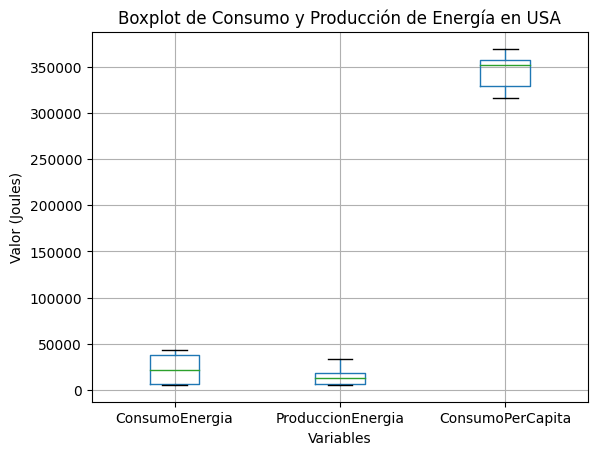

In [218]:
# Se crean los gráficos de boxplot para cada columna (1980-2019)
emisiones_usa.boxplot(column=['ConsumoEnergia', 'ProduccionEnergia', 'ConsumoPerCapita'])

# Personalizar el gráfico
plt.title('Boxplot de Consumo y Producción de Energía en USA')
plt.ylabel('Valor (Joules)')
plt.xlabel('Variables')

# Mostrar el gráfico
plt.show()

<Figure size 1200x600 with 0 Axes>

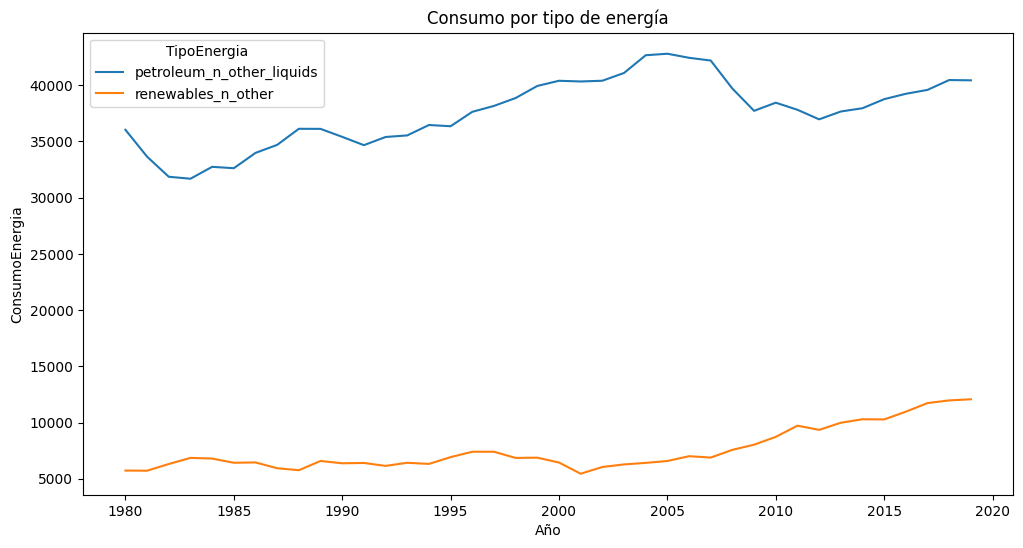

In [88]:
# Consumo de energía por tipo
plt.figure(figsize=(12,6))

sns.lineplot(data= emisiones_usa,x='Año', y='ConsumoEnergia', hue='TipoEnergia').set_title('Consumo por tipo de energía')
plt.show()

**Columna TotalEmisionesCO2**

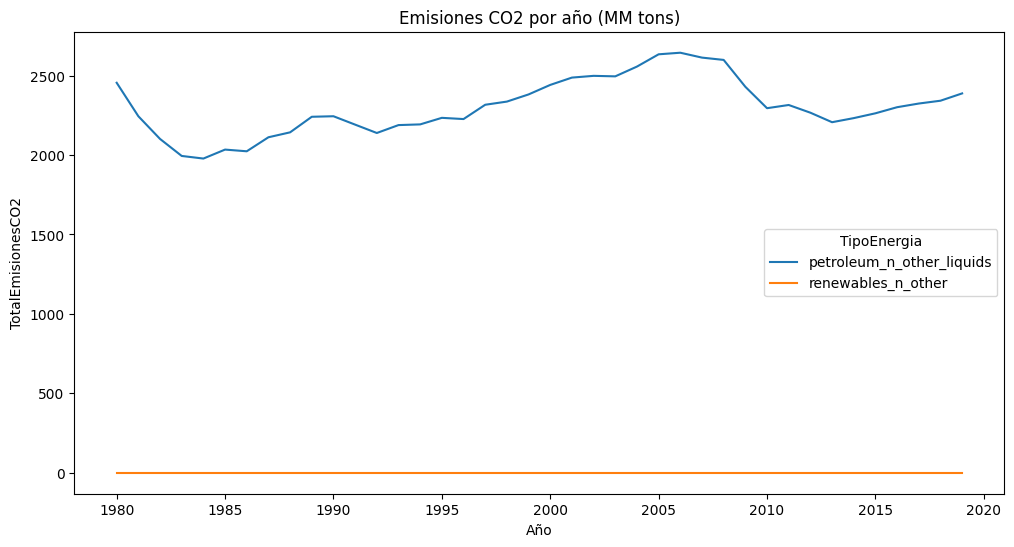

In [92]:
# Emisiones de CO2 por tipo de energía (MM tons)
plt.figure(figsize=(12,6))
sns.lineplot(data= emisiones_usa,x='Año', y='TotalEmisionesCO2', hue='TipoEnergia').set_title('Emisiones CO2 por año (MM tons)')
plt.show()

#### **Análisis Multivariado** ####

In [93]:
# En primera instancia, generamos variables dummy para la columna 'TipoEnergia' que se encuentra como variables categóricas, para poder relacionarlas con las demás columnas numéricas  
emisiones_usa_dummy = pd.get_dummies(emisiones_usa, columns=['TipoEnergia'])
emisiones_usa_dummy.head()

,Año,ConsumoEnergia,ProduccionEnergia,Poblacion,ConsumoPerCapita,TotalEmisionesCO2,TipoEnergia_petroleum_n_other_liquids,TipoEnergia_renewables_n_other
1323,1980,36039.76,21601.04,227119.0,362439.76,2455.243565,True,False
1325,1980,5727.23,5727.23,227119.0,362439.76,0.000000,False,True
2709,1981,33646.57,21536.20,229416.2,349778.68,2244.422124,True,False
2711,1981,5711.77,5711.77,229416.2,349778.68,0.000000,False,True
4095,1982,31861.09,21584.58,231608.5,332751.66,2101.609960,True,False


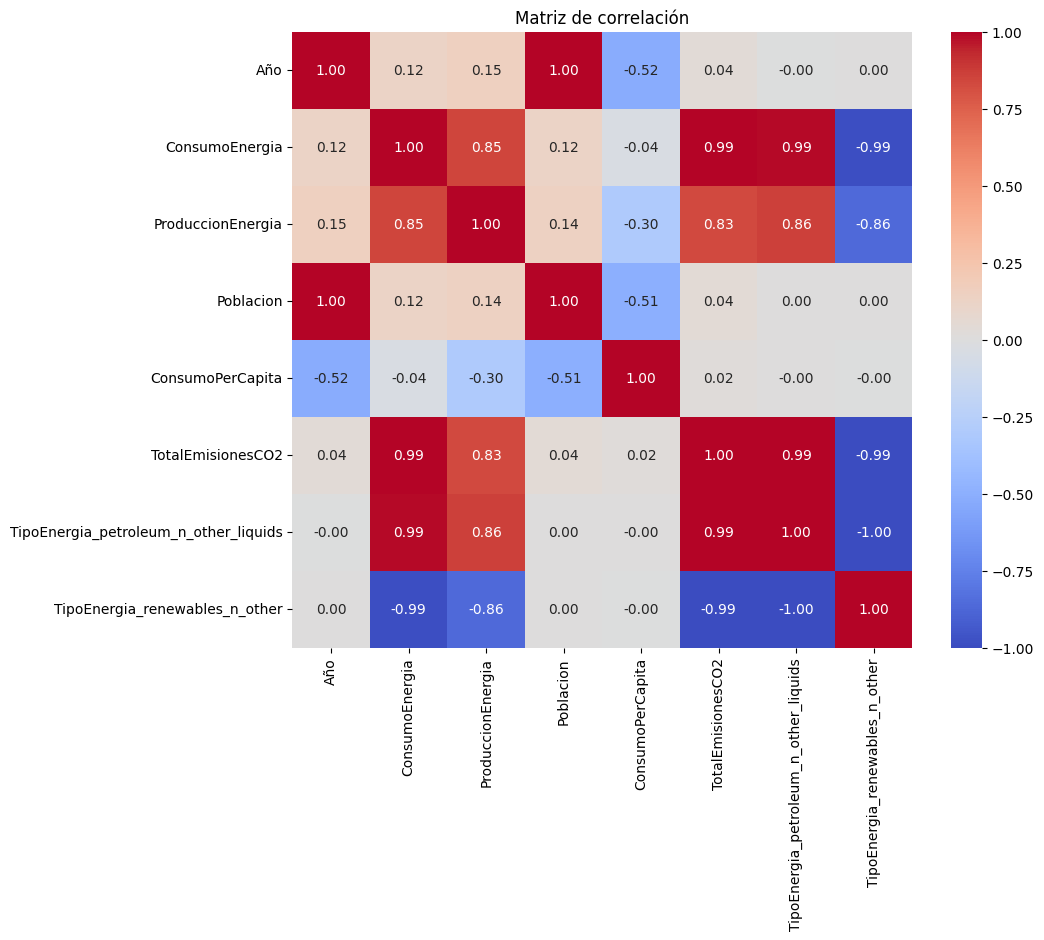

In [94]:
# Calcula la matriz de correlación
matriz_correlacion = emisiones_usa_dummy.corr()

# Visualiza la matriz de correlación como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Matriz de correlación')
plt.show()

#### **Exportación de los datos** ####

*Realizamos la exportación de los dataframes a formato .arrow*

1. *Convertimos el dataframe a polars*
2. *Convertimos el dataframe de polar a un objeto arrow*

In [224]:
# Convertimos el dataframe emisiones_usa
emisiones_usa = pl.from_pandas(emisiones_usa)
arrow_emisiones_usa = emisiones_usa.to_arrow()
pq.write_table(arrow_emisiones_usa, '../datasets/processed/emisiones_usa.arrow')

# EDA AUTOS ELECTRICOS
---
`En este cuadernillo se realiza el análisis exploratorio de un dataset que contiene registros y características de autos eléctricos`

### Importación de librerías
---

*Para este cuaderno usaremos las siguientes librerías: **pandas y matplotlib**.*

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from ckanapi import RemoteCKAN

#### **Web Scraping / Extracción de los datos** ####
---

Para este cuaderno usaremos la URL 'https://open.canada.ca/data/en/' y cargamos los registros directamente a un dataframe de pandas.

In [226]:
def scrape_ckan_data(resource_id, limit):
    # URL del CKAN
    ckan_url = 'https://open.canada.ca/data/en/'

    # Inicializar el objeto RemoteCKAN
    rc = RemoteCKAN(ckan_url)

    # Construir la consulta para recuperar datos específicos utilizando algunos campos del diccionario de datos
    query = {
        "resource_id": resource_id,
        "fields": [
            "Model year",
            "Make",
            "Model",
            "Vehicle class",
            "Motor (kW)",
            "Transmission",
            "Fuel type",
            "City (kWh/100 km)",
            "Highway (kWh/100 km)",
            "Combined (kWh/100 km)",
            "City (Le/100 km)",
            "Highway (Le/100 km)",
            "Combined (Le/100 km)",
            "Range (km)",
            "CO2 emissions (g/km)",
            "CO2 rating",
            "Smog rating",
            "Recharge time (h)"
        ],
        "limit": limit
    }

    # Realizar la consulta
    result = rc.action.datastore_search(**query)

    # Obtener los registros
    records = result['records']

    # Convertir los registros a un DataFrame de pandas
    df = pd.DataFrame(records)
    
    return df

# Llamar a la función para cada recurso y obtener los datos
df_electric = scrape_ckan_data("026e45b4-eb63-451f-b34f-d9308ea3a3d9", 668)  # Battery-electric vehicles (2012-2024)

### **Análisis Exploratorio Inicial** ###
---

*Vamos a realizar una **exploración de los datos** (EDA) antes de hacer transformación de los mismos, esto con el fin de **conocer las columnas** y determinar que campos son valiosos para nuestro análisis y así tener claro que pasos realizaremos en el ETL.*

**Nota:**: *Posterior al ETL realizaremos también un EDA enfocado en los datos y una descripción estadística.*

#### **Revisión de la extracción de los datos** ####

*Revisamos que los datos se cargaron adecuadamente en nuestro dataframe **df_electric**:*

1. *Usamos **head** para previsualizar los primeros registros del Dataframe.*

In [124]:
df_electric.head()

,Model year,Make,Model,Vehicle class,Motor (kW),Transmission,Fuel type,City (kWh/100 km),Highway (kWh/100 km),Combined (kWh/100 km),City (Le/100 km),Highway (Le/100 km),Combined (Le/100 km),Range (km),CO2 emissions (g/km),CO2 rating,Smog rating,Recharge time (h)
0,2012,Mitsubishi,i-MiEV,Subcompact,49,A1,B,16.9,21.4,18.7,1.9,2.4,2.1,100,0,n/a,n/a,7
1,2012,Nissan,LEAF,Mid-size,80,A1,B,19.3,23.0,21.1,2.2,2.6,2.4,117,0,n/a,n/a,7
2,2013,Ford,Focus Electric,Compact,107,A1,B,19.0,21.1,20.0,2.1,2.4,2.2,122,0,n/a,n/a,4
3,2013,Mitsubishi,i-MiEV,Subcompact,49,A1,B,16.9,21.4,18.7,1.9,2.4,2.1,100,0,n/a,n/a,7
4,2013,Nissan,LEAF,Mid-size,80,A1,B,19.3,23.0,21.1,2.2,2.6,2.4,117,0,n/a,n/a,7


#### **Revisión de la forma de los datos** ####

1. *Usamos **shape** obtener el número de filas y columnas del dataframe.*

In [125]:
df_electric.shape

(668, 18)

#### **Exploración de las columnas** ####

*Vamos a revisar qué columnas existen en el dataframe y de qué tipo son:*

1. *Usamos el método **info()** para listar las columnas, su valores no nulos y sus tipos.*
2. *Observamos que no tenemos registros nulos y que todas la variables son de tipo object*

In [126]:
df_electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Model year             668 non-null    object
 1   Make                   668 non-null    object
 2   Model                  668 non-null    object
 3   Vehicle class          668 non-null    object
 4   Motor (kW)             668 non-null    object
 5   Transmission           668 non-null    object
 6   Fuel type              668 non-null    object
 7   City (kWh/100 km)      668 non-null    object
 8   Highway (kWh/100 km)   668 non-null    object
 9   Combined (kWh/100 km)  668 non-null    object
 10  City (Le/100 km)       668 non-null    object
 11  Highway (Le/100 km)    668 non-null    object
 12  Combined (Le/100 km)   668 non-null    object
 13  Range (km)             668 non-null    object
 14  CO2 emissions (g/km)   668 non-null    object
 15  CO2 rating             

#### **Búsqueda y eliminación de duplicados** ####

*Revisamos los registros que pudieran estar duplicados basados en todas las columnas:*

1. *Usamos el método **drop_duplicates()***
2. *Observamos la cantidad de registros posterior a la eliminación de duplicados*

In [227]:
df_electric = df_electric.drop_duplicates()

df_electric.shape

(668, 18)

##### Revisamos cada una de las columnas

*Con el fin de explorar a nivel de detalle el dataset obtenido realizamos un análisis por columna con el fin de tomar decisiones sobre la ideonidad de los datos y depurar información innecesaria.*

In [128]:
df_electric.columns

Index(['Model year', 'Make', 'Model', 'Vehicle class', 'Motor (kW)',
       'Transmission', 'Fuel type', 'City (kWh/100 km)',
       'Highway (kWh/100 km)', 'Combined (kWh/100 km)', 'City (Le/100 km)',
       'Highway (Le/100 km)', 'Combined (Le/100 km)', 'Range (km)',
       'CO2 emissions (g/km)', 'CO2 rating', 'Smog rating',
       'Recharge time (h)'],
      dtype='object')

**Columnas a eliminar**

In [228]:
#Vamos a trabajar con las columnas AñoModelo, Fabricante, Modelo, Consumo(kwh/milla), EmisionesCO2(gramos/milla), TiempoRecarga, por lo que las demas columnas se eliminan
columnas_a_eliminar2 = ['Transmission', 'Vehicle class', 'Motor (kW)', 'City (Le/100 km)', 'Range (km)', 'Fuel type', 'Smog rating', 'Highway (kWh/100 km)', 'CO2 rating', 'City (kWh/100 km)', 'Highway (Le/100 km)', 'Combined (Le/100 km)']
df_electric = df_electric.drop(columnas_a_eliminar2, axis=1)

#### **Conversión de tipo de datos** ####

In [229]:
# Convertimos las columnas object a formatos más eficientes
df_electric['Model year'] = df_electric['Model year'].astype(int)
df_electric['Make'] = df_electric['Make'].astype(str)
df_electric['Model'] = df_electric['Model'].astype(str)
df_electric['Combined (kWh/100 km)'] = df_electric['Combined (kWh/100 km)'].astype(float)
df_electric['CO2 emissions (g/km)'] = df_electric['CO2 emissions (g/km)'].astype(float)
df_electric['Recharge time (h)'] = df_electric['Recharge time (h)'].astype(float)

In [231]:
# Renombramos las columnas para mayor claridad
rename = {'Model year': 'AñoModelo',
          'Make': 'Fabricante',
          'Model': 'Modelo',
          'Combined (kWh/100 km)': 'Consumo(kwh/milla)',
          'CO2 emissions (g/km)': 'EmisionesCO2(gramos/milla)',
          'Recharge time (h)': 'TiempoRecarga'} 
df_electric = df_electric.rename(columns=rename)

In [135]:
# Corroboramos los cambios
df_electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AñoModelo                   668 non-null    int32  
 1   Fabricante                  668 non-null    object 
 2   Modelo                      668 non-null    object 
 3   Consumo(kwh/milla)          668 non-null    float64
 4   EmisionesCO2(gramos/milla)  668 non-null    float64
 5   TiempoRecarga               668 non-null    float64
dtypes: float64(3), int32(1), object(2)
memory usage: 28.8+ KB


In [136]:
df_electric

,AñoModelo,Fabricante,Modelo,Consumo(kwh/milla),EmisionesCO2(gramos/milla),TiempoRecarga
0,2012,Mitsubishi,i-MiEV,18.7,0.0,7.0
1,2012,Nissan,LEAF,21.1,0.0,7.0
2,2013,Ford,Focus Electric,20.0,0.0,4.0
3,2013,Mitsubishi,i-MiEV,18.7,0.0,7.0
4,2013,Nissan,LEAF,21.1,0.0,7.0
...,...,...,...,...,...,...
663,2024,Volkswagen,ID.4 Pro S,18.5,0.0,8.0
664,2024,Volkswagen,ID.4 AWD Pro,20.5,0.0,8.0
665,2024,Volkswagen,ID.4 AWD Pro S,20.5,0.0,8.0
666,2024,Volvo,C40 Recharge,19.6,0.0,8.0


**Columna Consumo(kwh/milla)**

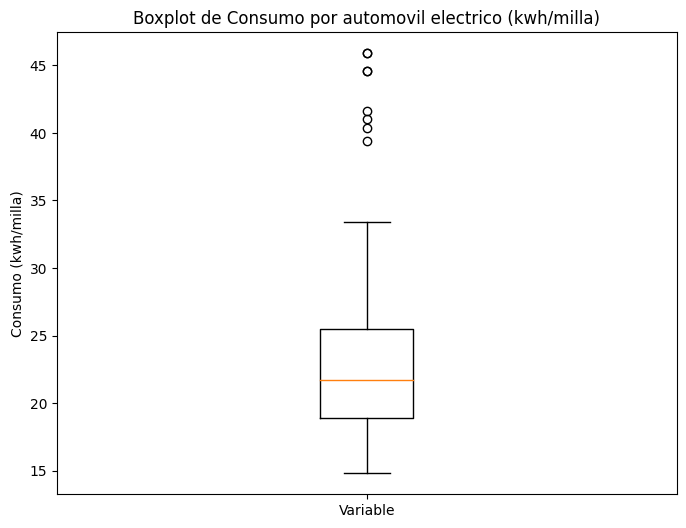

In [144]:
# Creamos boxplot de esta columna
plt.figure(figsize=(8, 6))
plt.boxplot(df_electric['Consumo(kwh/milla)'])

# Establecer las etiquetas del eje x
plt.xticks([1], ['Variable'])

# Establecer el título y las etiquetas de los ejes
plt.title('Boxplot de Consumo por automovil electrico (kwh/milla)')
plt.ylabel('Consumo (kwh/milla)')

# Mostrar el boxplot
plt.show()

**Columna TiempoRecarga**

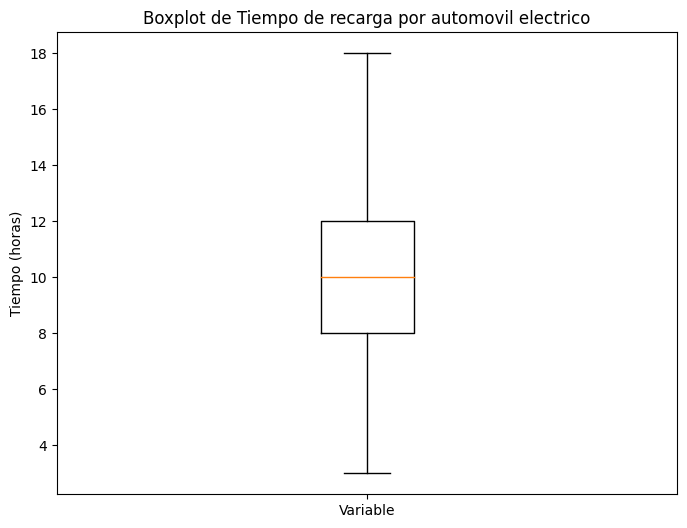

In [148]:
#Generamos un boxplot para ver los tiempos de recarga
plt.figure(figsize=(8, 6))
plt.boxplot(df_electric['TiempoRecarga'])

# Establecer las etiquetas del eje x
plt.xticks([1], ['Variable'])

# Establecer el título y las etiquetas de los ejes
plt.title('Boxplot de Tiempo de recarga por automovil electrico')
plt.ylabel('Tiempo (horas)')

# Mostrar el boxplot
plt.show()

**Columna EmisionesCO2(gramos/milla)**

In [146]:
# Los autos eléctricos no generan emisiones de CO2
df_electric['EmisionesCO2(gramos/milla)'].unique()

array([0.])

#### **Vehículos mas eficientes en Consumo(kwh/milla)** ####

In [195]:
top_10_eficientes_electrico = df_electric.sort_values(by='Consumo(kwh/milla)', ascending=True).head(15)
top_10_eficientes_electrico

,AñoModelo,Fabricante,Modelo,Consumo(kwh/milla),EmisionesCO2(gramos/milla),TiempoRecarga
210,2021,Tesla,Model 3 Standard Range Plus,14.8,0.0,8.5
158,2020,Tesla,Model 3 Standard Range Plus,14.9,0.0,8.5
359,2023,Hyundai,IONIQ 6 Long Range (18'' Wheels),14.9,0.0,7.5
378,2023,Lucid,"Air Pure (19"" Wheels)",14.9,0.0,10.0
380,2023,Lucid,"Air Touring (19"" Wheels)",14.9,0.0,10.0
551,2024,Hyundai,IONIQ 6 Long Range (18'' Wheels),14.9,0.0,7.5
209,2021,Tesla,Model 3 Standard Range,15.2,0.0,3.7
568,2024,Lucid,"Air Pure (19"" Wheels)",15.3,0.0,10.0
641,2024,Tesla,Model 3 RWD (Import),15.4,0.0,8.5
65,2017,Hyundai,IONIQ Electric,15.5,0.0,4.0


#### **Visualización** ####

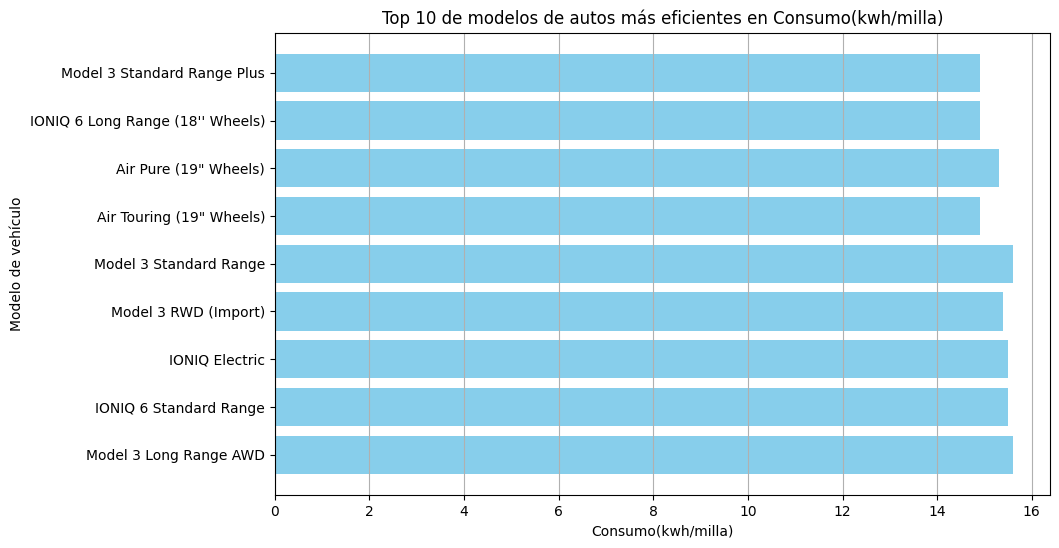

In [197]:
# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.barh(top_10_eficientes_electrico['Modelo'], top_10_eficientes_electrico['Consumo(kwh/milla)'], color='skyblue')
plt.xlabel('Consumo(kwh/milla)')
plt.ylabel('Modelo de vehículo')
plt.title('Top 10 de modelos de autos más eficientes en Consumo(kwh/milla)')
plt.gca().invert_yaxis()  # Invertir el eje y para que el modelo más eficiente esté en la parte superior
plt.grid(axis='x')  # Agregar líneas de rejilla solo en el eje x
plt.show()

#### **Exportación de los datos** ####

*Realizamos la exportación de los dataframes a formato .arrow*

1. *Convertimos el dataframe a polars*
2. *Convertimos el dataframe de polar a un objeto arrow*

In [233]:
# Convertimos el dataframe emisiones_usa
df_electric = pl.from_pandas(df_electric)
arrow_df_electric = df_electric.to_arrow()
pq.write_table(arrow_df_electric, '../datasets/processed/df_electricos.arrow')

# EDA AUTOMOVILES A COMBUSTIBLE
---
`En este cuadernillo se realiza el análisis exploratorio de un dataset que contiene registros y características de automóviles a combustible`

### Importación de librerías
---

*Para este cuaderno usaremos las siguientes librerías: **pandas y matplotlib**.*

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
from ckanapi import RemoteCKAN

#### **Web Scraping / Extracción de los datos** ####
---

Para este cuaderno usaremos la URL 'https://open.canada.ca/data/en/' y cargamos los registros directamente a un dataframe de pandas.

In [156]:
def scrape_ckan_data(resource_id, limit):
    # URL del CKAN
    ckan_url = 'https://open.canada.ca/data/en/'

    # Inicializar el objeto RemoteCKAN
    rc = RemoteCKAN(ckan_url)

    # Construir la consulta para recuperar datos específicos utilizando algunos campos del diccionario de datos
    query = {
        "resource_id": resource_id,
        "fields": [
            "Model year",
            "Make",
            "Model",
            "Vehicle class",
            "Engine size (L)",
            "Cylinders",
            "Transmission",
            "Fuel type",
            "City (L/100 km)",
            "Highway (L/100 km)",
            "Combined (L/100 km)",
            "Combined (mpg)",
            "CO2 emissions (g/km)",
            "CO2 rating",
            "Smog rating"
        ],
        "limit": limit
    }

    # Realizar la consulta
    result = rc.action.datastore_search(**query)

    # Obtener los registros
    records = result['records']

    # Convertir los registros a un DataFrame de pandas
    df = pd.DataFrame(records)
    
    return df

# Llamar a la función para cada recurso y obtener los datos
df_2015_2019 = scrape_ckan_data("332be680-9577-42c6-8c47-a0380ef48c5e", 5432) #Fuel consumption ratings (2015-2019)
df_2020 = scrape_ckan_data("56a89c09-d609-41cd-8838-9dd9905d3cfc", 975) #2020 Fuel Consumption Ratings (2023-02-03)
df_2021 = scrape_ckan_data("f2e53a2b-e075-473a-9a9c-5d7bef68d07d", 971) #2021 Fuel Consumption Ratings (2023-02-03)
df_2022 = scrape_ckan_data("87fc1b5e-fafc-4d44-ac52-66656fc2a245", 971) #2022 Fuel Consumption Ratings (2023-08-18)

### **Análisis Exploratorio Inicial** ###
---

*Vamos a realizar una **exploración de los datos** (EDA) antes de hacer transformación de los mismos, esto con el fin de **conocer las columnas** y determinar que campos son valiosos para nuestro análisis y así tener claro que pasos realizaremos en el ETL.*

**Nota:**: *Posterior al ETL realizaremos también un EDA enfocado en los datos y una descripción estadística.*

#### **Revisión de la extracción de los datos** ####

*Revisamos que los datos se cargaron adecuadamente en nuestro dataframe **df15_19, df20 y df21**:*

1. *Usamos **head** para previsualizar los primeros registros del Dataframe.*

In [162]:
df_2015_2019.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2015,Acura,ILX,Compact,2.0,4,AS5,Z,9.7,6.7,8.3,34,191,n/a,n/a
1,2015,Acura,ILX,Compact,2.4,4,M6,Z,10.8,7.4,9.3,30,214,n/a,n/a
2,2015,Acura,ILX Hybrid,Compact,1.5,4,AV7,Z,6.0,6.1,6.1,46,140,n/a,n/a
3,2015,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,n/a,n/a
4,2015,Acura,RDX AWD,Sport utility vehicle: Small,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,n/a,n/a


In [163]:
df_2020.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2020,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,199,6,3
1,2020,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS9,Z,12.3,9.2,10.9,26,254,4,3
2,2020,Acura,MDX SH-AWD A-SPEC,Sport utility vehicle: Small,3.5,6,AS9,Z,12.2,9.5,11.0,26,258,4,3
3,2020,Acura,MDX Hybrid AWD,Sport utility vehicle: Small,3.0,6,AM7,Z,9.1,9.0,9.0,31,210,5,3
4,2020,Acura,NSX,Two-seater,3.5,6,AM9,Z,11.1,10.8,11.0,26,261,4,3


In [164]:
df_2021.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2021,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,199,6,3
1,2021,Acura,NSX,Two-seater,3.5,6,AM9,Z,11.1,10.8,11.0,26,256,4,3
2,2021,Acura,RDX SH-AWD,Sport utility vehicle: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6
3,2021,Acura,RDX SH-AWD A-SPEC,Sport utility vehicle: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6
4,2021,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7


In [165]:
df_2022.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3
1,2022,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
2,2022,Acura,MDX Type S,Sport utility vehicle: Standard,3.0,6,AS10,Z,13.8,11.2,12.4,23,291,4,5
3,2022,Acura,NSX,Two-seater,3.5,6,AM9,Z,11.1,10.8,11.0,26,256,5,3
4,2022,Acura,RDX SH-AWD,Sport utility vehicle: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6


In [172]:
# Al ser tablas con campos idénticos, las podemos concatenar de forma vertical (apilar) y así trabajar con un solo dataframe que llamaremos df15_22
df15_22 = pd.concat([df_2015_2019, df_2020, df_2021, df_2022], axis=0, ignore_index=True)
df15_22

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2015,Acura,ILX,Compact,2.0,4,AS5,Z,9.7,6.7,8.3,34,191,n/a,n/a
1,2015,Acura,ILX,Compact,2.4,4,M6,Z,10.8,7.4,9.3,30,214,n/a,n/a
2,2015,Acura,ILX Hybrid,Compact,1.5,4,AV7,Z,6.0,6.1,6.1,46,140,n/a,n/a
3,2015,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,n/a,n/a
4,2015,Acura,RDX AWD,Sport utility vehicle: Small,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,n/a,n/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8342,2022,Volvo,S90 B6 AWD,Mid-size,2.0,4,AS8,Z,10.4,7.5,9.1,31,212,5,7
8343,2022,Volvo,V60 T6 AWD,Station wagon: Small,2.0,4,AS8,Z,11.3,7.5,9.6,29,224,5,7
8344,2022,Volvo,V60 CC T5 AWD,Station wagon: Small,2.0,4,AS8,Z,10.9,7.7,9.5,30,221,5,5
8345,2022,Volvo,V90 CC B6 AWD,Station wagon: Mid-size,2.0,4,AS8,Z,10.6,8.1,9.5,30,222,5,7


#### **Revisión de la forma de los datos** ####

1. *Usamos **shape** obtener el número de filas y columnas del dataframe.*

In [173]:
df15_22.shape

(8347, 15)

#### **Exploración de las columnas** ####

*Vamos a revisar qué columnas existen en el dataframe y de qué tipo son:*

1. *Usamos el método **info()** para listar las columnas, su valores no nulos y sus tipos.*
2. *Observamos que no tenemos registros nulos y que todas la variables son de tipo object*

In [174]:
df15_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8347 entries, 0 to 8346
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Model year            8347 non-null   object
 1   Make                  8347 non-null   object
 2   Model                 8347 non-null   object
 3   Vehicle class         8347 non-null   object
 4   Engine size (L)       8347 non-null   object
 5   Cylinders             8347 non-null   object
 6   Transmission          8347 non-null   object
 7   Fuel type             8347 non-null   object
 8   City (L/100 km)       8347 non-null   object
 9   Highway (L/100 km)    8347 non-null   object
 10  Combined (L/100 km)   8347 non-null   object
 11  Combined (mpg)        8347 non-null   object
 12  CO2 emissions (g/km)  8347 non-null   object
 13  CO2 rating            8347 non-null   object
 14  Smog rating           8347 non-null   object
dtypes: object(15)
memory usage: 978.3+ KB


#### **Búsqueda y eliminación de duplicados** ####

*Revisamos los registros que pudieran estar duplicados basados en todas las columnas:*

1. *Usamos el método **drop_duplicates()***
2. *Observamos la cantidad de registros posterior a la eliminación de duplicados*

In [175]:
df15_22 = df15_22.drop_duplicates()

df15_22.shape

(8347, 15)

In [176]:
df15_22.columns

Index(['Model year', 'Make', 'Model', 'Vehicle class', 'Engine size (L)',
       'Cylinders', 'Transmission', 'Fuel type', 'City (L/100 km)',
       'Highway (L/100 km)', 'Combined (L/100 km)', 'Combined (mpg)',
       'CO2 emissions (g/km)', 'CO2 rating', 'Smog rating'],
      dtype='object')

**Columnas a eliminar**

In [177]:
#Vamos a trabajar con las columnas AñoModelo, Fabricante, Modelo, Consumo(galones/milla), EmisionesCO2(gramos/milla)
columnas_a_eliminar3 = ['Vehicle class', 'Engine size (L)', 'Cylinders', 'Transmission', 'Fuel type', 'City (L/100 km)', 'Highway (L/100 km)', 'Combined (mpg)', 'CO2 rating', 'Smog rating']
df15_22 = df15_22.drop(columnas_a_eliminar3, axis=1)

#### **Conversión de tipo de datos** ####

In [179]:
df15_22.columns

Index(['Model year', 'Make', 'Model', 'Combined (L/100 km)',
       'CO2 emissions (g/km)'],
      dtype='object')

In [180]:
# Convertimos las columnas object a formatos más eficientes
df15_22['Model year'] = df15_22['Model year'].astype(int)
df15_22['Make'] = df15_22['Make'].astype(str)
df15_22['Model'] = df15_22['Model'].astype(str)
df15_22['Combined (L/100 km)'] = df15_22['Combined (L/100 km)'].astype(float)
df15_22['CO2 emissions (g/km)'] = df15_22['CO2 emissions (g/km)'].astype(float)

In [181]:
# Renombramos las columnas para mayor claridad
rename2 = {'Model year': 'AñoModelo',
          'Make': 'Fabricante',
          'Model': 'Modelo',
          'Combined (L/100 km)': 'Consumo(galones/milla)',
          'CO2 emissions (g/km)': 'EmisionesCO2(gramos/milla)'} 
df15_22 = df15_22.rename(columns=rename2)

In [182]:
# Corroboramos los cambios
df15_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8347 entries, 0 to 8346
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AñoModelo                   8347 non-null   int32  
 1   Fabricante                  8347 non-null   object 
 2   Modelo                      8347 non-null   object 
 3   Consumo(galones/milla)      8347 non-null   float64
 4   EmisionesCO2(gramos/milla)  8347 non-null   float64
dtypes: float64(2), int32(1), object(2)
memory usage: 293.6+ KB


In [183]:
# Filtramos por año ya que nos interesan solo los modelos del 2018 en adelante
df18_22 = df15_22[df15_22['AñoModelo'] >= 2018]

# Convertimos las columnas L/100km a galones/milla
df18_22['Consumo(galones/milla)'] = df18_22['Consumo(galones/milla)']*1.60934/(100*3.78541)

C:\Users\cquir\AppData\Local\Temp\ipykernel_14972\2352085605.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df18_22['Consumo(galones/milla)'] = df18_22['Consumo(galones/milla)']*1.60934/(100*3.78541)


In [236]:
df18_22 = df18_22.reset_index(drop=True)
df18_22

,AñoModelo,Fabricante,Modelo,Consumo(galones/milla),EmisionesCO2(gramos/milla)
0,2018,Acura,ILX,0.034862,192.0
1,2018,Acura,MDX SH-AWD,0.046766,259.0
2,2018,Acura,MDX SH-AWD Elite,0.045490,251.0
3,2018,Acura,MDX Hybrid AWD,0.038263,210.0
4,2018,Acura,NSX,0.046766,261.0
...,...,...,...,...,...
5050,2022,Volvo,S90 B6 AWD,0.038688,212.0
5051,2022,Volvo,V60 T6 AWD,0.040814,224.0
5052,2022,Volvo,V60 CC T5 AWD,0.040389,221.0
5053,2022,Volvo,V90 CC B6 AWD,0.040389,222.0


##### Revisamos cada una de las columnas

*Con el fin de explorar a nivel de detalle el dataset obtenido realizamos un análisis por columna con el fin de tomar decisiones sobre la ideonidad de los datos y depurar información innecesaria.*

**Columna Consumo(galones/milla)**

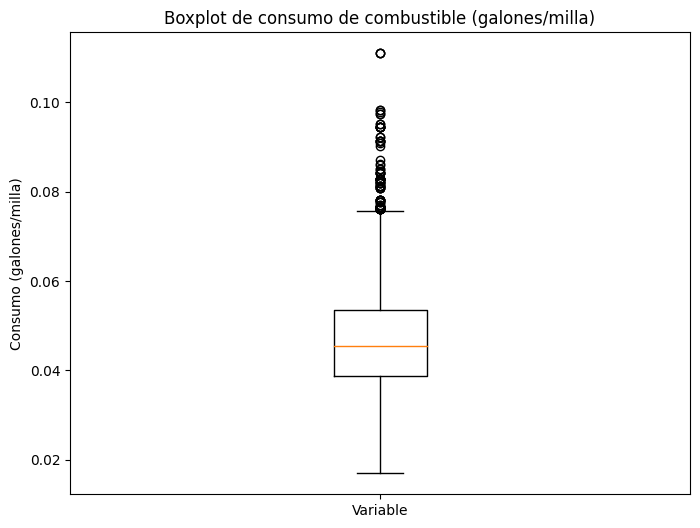

In [191]:
#Generamos un boxplot para ver el consumo de combustible
plt.figure(figsize=(8, 6))
plt.boxplot(df18_22['Consumo(galones/milla)'])

# Establecer las etiquetas del eje x
plt.xticks([1], ['Variable'])

# Establecer el título y las etiquetas de los ejes
plt.title('Boxplot de consumo de combustible (galones/milla)')
plt.ylabel('Consumo (galones/milla)')

# Mostrar el boxplot
plt.show()

**Columna EmisionesCO2(gramos/milla)**

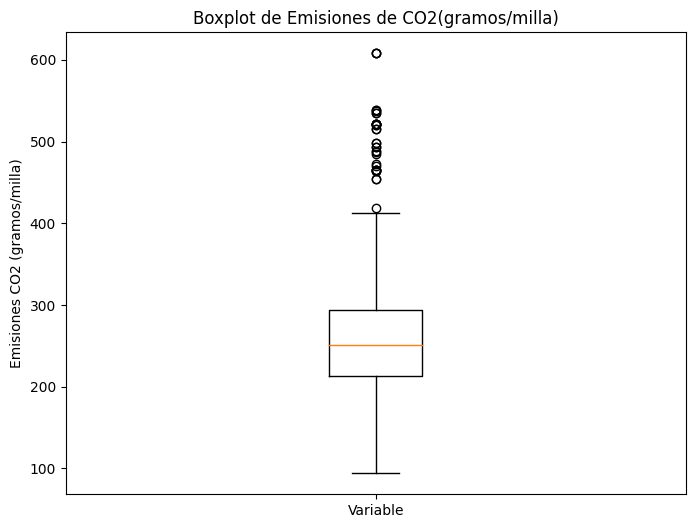

In [192]:
#Generamos un boxplot para ver las emisiones de CO2
plt.figure(figsize=(8, 6))
plt.boxplot(df18_22['EmisionesCO2(gramos/milla)'])

# Establecer las etiquetas del eje x
plt.xticks([1], ['Variable'])

# Establecer el título y las etiquetas de los ejes
plt.title('Boxplot de Emisiones de CO2(gramos/milla)')
plt.ylabel('Emisiones CO2 (gramos/milla)')

# Mostrar el boxplot
plt.show()

#### **Vehículos mas eficientes en consumo(galones/milla)** ####

In [237]:
top_10_eficientes_18_22 = df18_22.sort_values(by='Consumo(galones/milla)', ascending=True).head(15)
top_10_eficientes_18_22

,AñoModelo,Fabricante,Modelo,Consumo(galones/milla),EmisionesCO2(gramos/milla)
3571,2021,Hyundai,IONIQ Blue,0.017006,94.0
4548,2022,Hyundai,IONIQ Blue,0.017006,94.0
529,2018,Hyundai,IONIQ Blue,0.017431,96.0
2604,2020,Hyundai,IONIQ Blue,0.017431,96.0
1565,2019,Hyundai,IONIQ Blue,0.017431,96.0
3570,2021,Hyundai,IONIQ,0.017856,99.0
4547,2022,Hyundai,IONIQ,0.017856,99.0
2603,2020,Hyundai,IONIQ,0.017856,99.0
1564,2019,Hyundai,IONIQ,0.018281,104.0
528,2018,Hyundai,IONIQ,0.018281,102.0


#### **Visualización** ####

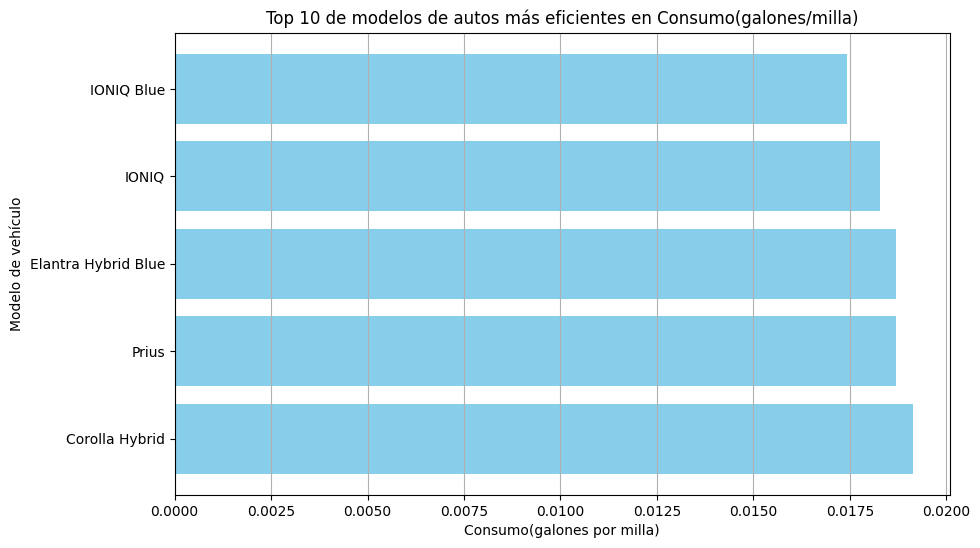

In [194]:
# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.barh(top_10_eficientes_18_22['Modelo'], top_10_eficientes_18_22['Consumo(galones/milla)'], color='skyblue')
plt.xlabel('Consumo(galones por milla)')
plt.ylabel('Modelo de vehículo')
plt.title('Top 10 de modelos de autos más eficientes en Consumo(galones/milla)')
plt.gca().invert_yaxis()  # Invertir el eje y para que el modelo más eficiente esté en la parte superior
plt.grid(axis='x')  # Agregar líneas de rejilla solo en el eje x
plt.show()

#### **Exportación de los datos** ####

*Realizamos la exportación de los dataframes a formato .arrow*

1. *Convertimos el dataframe a polars*
2. *Convertimos el dataframe de polar a un objeto arrow*

In [238]:
# Convertimos el dataframe emisiones_usa
df18_22 = pl.from_pandas(df18_22)
arrow_df18_22 = df18_22.to_arrow()
pq.write_table(arrow_df18_22, '../datasets/processed/df_automoviles_18_22.arrow')